# Example notebook for pairwise registration using GreedyFHist



### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.array`.

In [1]:
import matplotlib.pyplot as plt

from greedyfhist.data_types import Image, Pointset
from greedyfhist.registration import GreedyFHist, RegistrationResult
from greedyfhist.options import RegistrationOptions
from greedyfhist.utils.io import read_image, write_to_ometiffile

In [2]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'

moving_image = Image.load_from_path(path_to_moving_image)
fixed_image = Image.load_from_path(path_to_fixed_image)

Text(0.5, 1.0, 'Fixed Image')

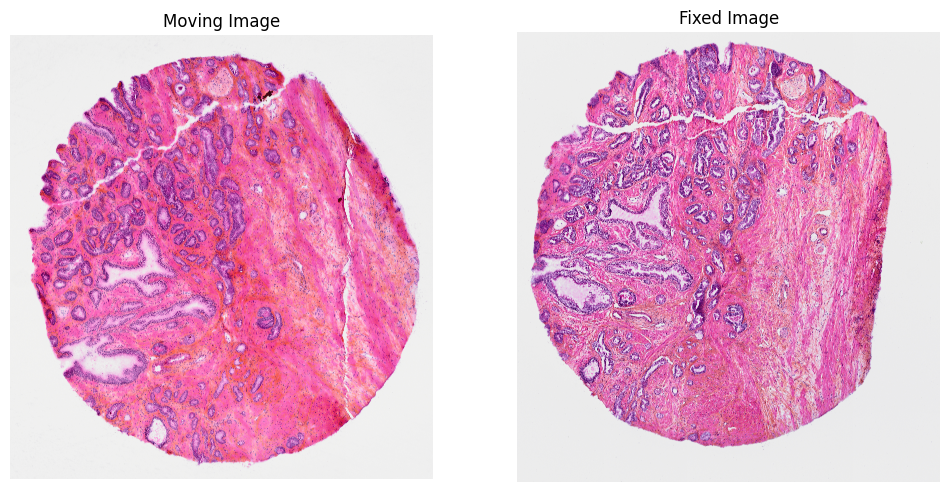

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')

### Step 2: Setting registration options and performing registration.

In [4]:
# Default options do not need to be parsed
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
# For large images we recommend to use downscaling.
options.pre_sampling_factor = 0.25

# init registerer
registerer = GreedyFHist.load_from_config()

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

A registration result consists of 2 transformations: A forward transformation from moving to fixed image space and a backward transformation from fixed to moving image space. Internally transformations are executed using SimpleITK. Forward transformations are used to transform image data, backward transformations are used for pointset valued data.

In [5]:
warped_moving_image = registerer.transform_image(moving_image.data, registration_result.registration_transforms.forward_transform)

Text(0.5, 1.0, 'Transformed Image')

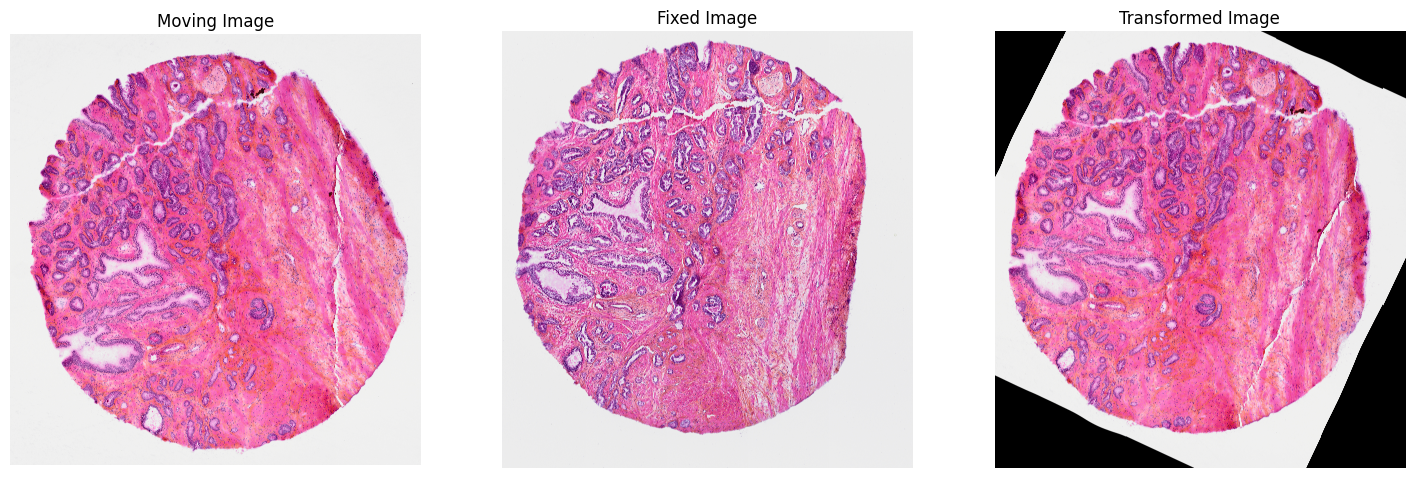

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(warped_moving_image)
axs[2].set_title('Transformed Image')

### Step 3: Saving and loading transformation data

Transformations can be stored and loaded at a later point.

In [7]:
registration_result.to_file('saved_transform')
loaded_reg_result = RegistrationResult.load('saved_transform')

In [8]:
warped_image2 = registerer.transform_image(moving_image.data, loaded_reg_result.registration_transforms.forward_transform, 'LINEAR')

In [9]:
ps  = Pointset.load_from_path('../pairwise_examples/annotations/moving_pointset.csv')
warped_ps = registerer.transform_pointset(ps.to_numpy(), loaded_reg_result.registration_transforms.backward_transform)

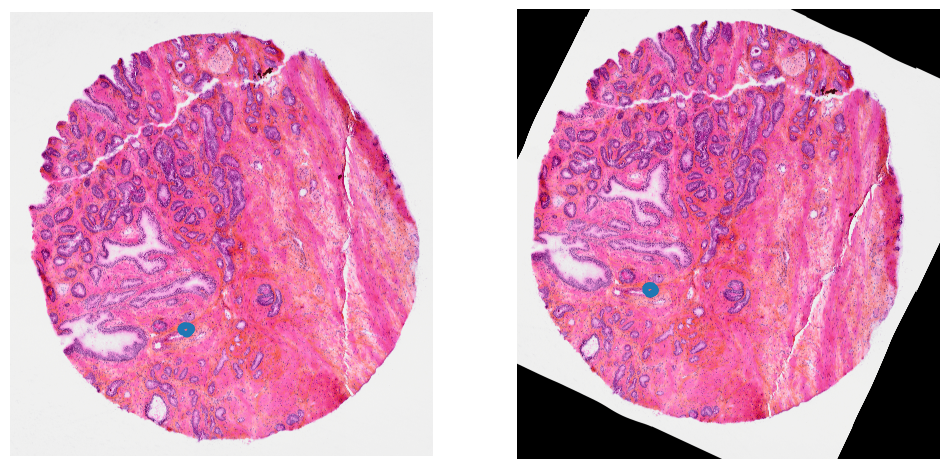

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
ps_np = ps.to_numpy()
axs[0].plot(ps_np[:, 0], ps_np[:, 1], '.')
axs[1].imshow(warped_image2)
axs[1].plot(warped_ps[:, 0], warped_ps[:, 1], '.')